In [17]:
import os
import glob
import time
import torchvision
import numpy as np
from PIL import Image
import cv2 as cv
from pathlib import Path

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
import torch.nn.functional as F


In [ ]:
#Step 2: Load the Dataset

In [16]:
Ls = np.load('C:/Users/Plaksha/Desktop/ISB/Project _CV/gray_scale.npy')
abs1 = np.load('C:/Users/Plaksha/Desktop/ISB/Project _CV/ab1.npy')
abs2 = np.load('C:/Users/Plaksha/Desktop/ISB/Project _CV/ab2.npy')
abs3 = np.load('C:/Users/Plaksha/Desktop/ISB/Project _CV/ab3.npy')

# Concatenate the 'ab' components
abs_ = np.concatenate((abs1, abs2, abs3))

# Define the dataset
dataset = (Ls, abs_)

print("Dataset loaded successfully")


Dataset loaded successfully


In [ ]:
#Step 3: Creating the Dataset Class and DataLoader

In [18]:
# Custom Dataset class for image colorization
class ImageColorizationDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset[0])

    def __getitem__(self, idx):
        L = np.array(self.dataset[0][idx]).reshape((224, 224, 1))
        L = transforms.ToTensor()(L)
        
        ab = np.array(self.dataset[1][idx])
        ab = transforms.ToTensor()(ab)
        
        return {'L': L, 'ab': ab}

batch_size = 16

# Prepare the Datasets
train_dataset = ImageColorizationDataset(dataset)
val_dataset = ImageColorizationDataset(dataset)

# Build DataLoaders
train_dl = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

print("DataLoaders created successfully")


DataLoaders created successfully


In [19]:
# Define the Generator (U-Net) model
def build_res_unet(n_input=1, n_output=2, size=224):
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

# Define the Discriminator model
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                  for i in range(n_down)]
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)]
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True):
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Initialize the models
net_G = build_res_unet()
net_D = PatchDiscriminator(input_c=3)

print("Generator and Discriminator models defined successfully")


Generator and Discriminator models defined successfully


In [20]:
# Initialize weights function
def init_weights(net, init='norm', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
    net.apply(init_func)
    print(f"Model initialized with {init} initialization")
    return net

# GAN loss class
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))    
        self.register_buffer('fake_label', torch.tensor(fake_label))  
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

# Utility class to track average meter
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

# Utility function to create loss meters
def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

# Function to update losses
def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

# Function to log results
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

# Function to visualize results
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    L = L  * 100.
    ab = (ab-0.5) * 128.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=False):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

# Main training loop
def train_model(model, train_dl, val_dl, epochs, display_every=200):
    data = next(iter(val_dl))
    for e in range(epochs):
        loss_meter_dict = create_loss_meters()
        i = 0
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0))
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict)
                visualize(model, data, save=False)
        if e % 5 == 0:
            torch.save(model.state_dict(), f"/path/to/save/model_{e+1}.pt")

print("Training functions and loss definitions are ready")


Training functions and loss definitions are ready


In [21]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device, dtype=torch.float)
        self.ab = data['ab'].to(self.device, dtype=torch.float)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

print("MainModel class defined successfully")


MainModel class defined successfully


In [22]:
def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model


Model initialized with norm initialization


  0%|          | 0/1563 [00:00<?, ?it/s]


Epoch 1/10
Iteration 50/1563
loss_D_fake: 0.58418
loss_D_real: 0.51936
loss_D: 0.55177
loss_G_GAN: 1.26209
loss_G_L1: 18.38892
loss_G: 19.65100


C:\Users\Plaksha\AppData\Local\Temp\ipykernel_10528\414019884.py:93: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
C:\Users\Plaksha\AppData\Local\Temp\ipykernel_10528\414019884.py:93: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 8 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
C:\Users\Plaksha\AppData\Local\Temp\ipykernel_10528\414019884.py:93: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
C:\Users\Plaksha\AppData\Local\Temp\ipykernel_10528\414019884.py:93: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)
C:\Users\Plaksha\AppData\Local\Temp\ipykernel_10528\414019884.py:93: UserWarning: Conversion from CIE-LAB, v

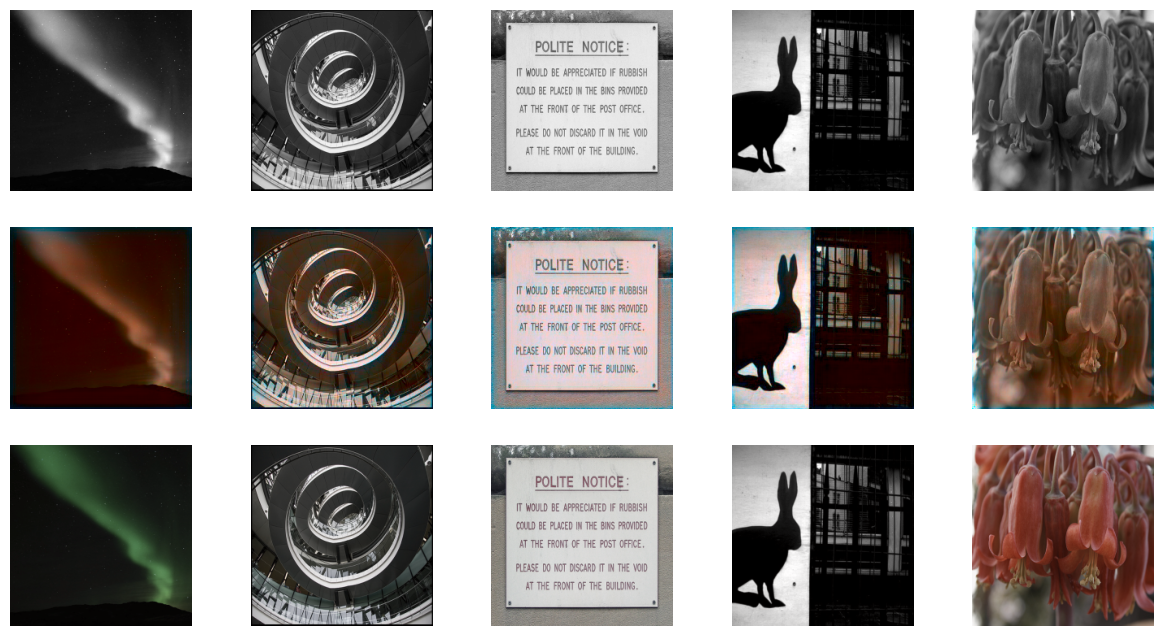


Epoch 1/10
Iteration 100/1563
loss_D_fake: 0.49886
loss_D_real: 0.46930
loss_D: 0.48408
loss_G_GAN: 1.46761
loss_G_L1: 13.01927
loss_G: 14.48688


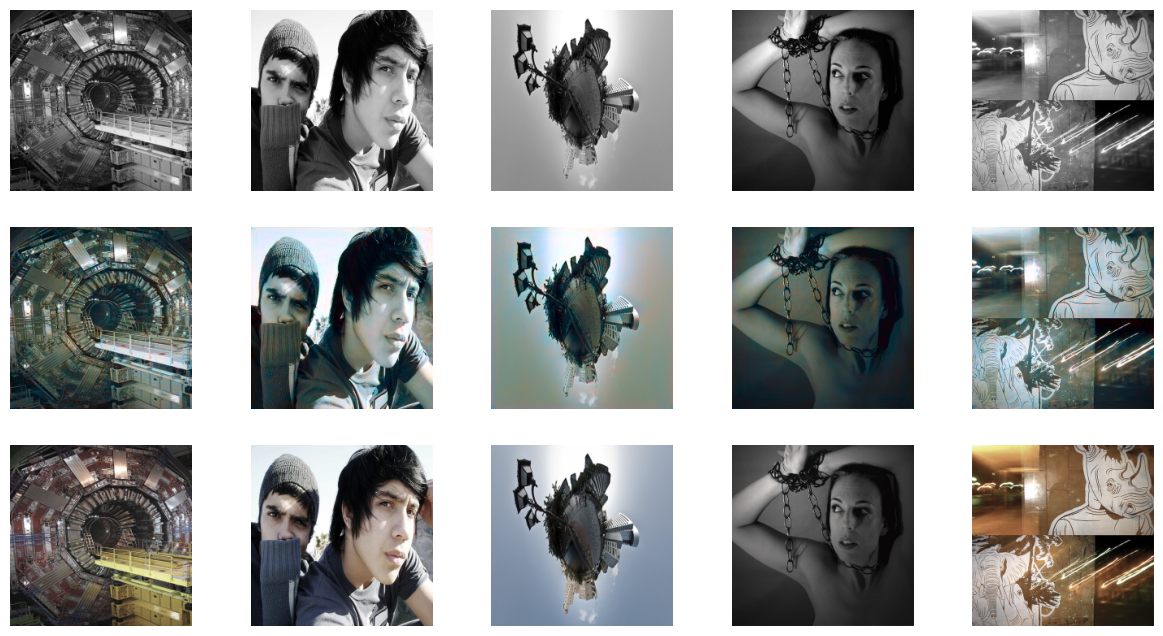


Epoch 1/10
Iteration 150/1563
loss_D_fake: 0.49627
loss_D_real: 0.47787
loss_D: 0.48707
loss_G_GAN: 1.50317
loss_G_L1: 11.09893
loss_G: 12.60210


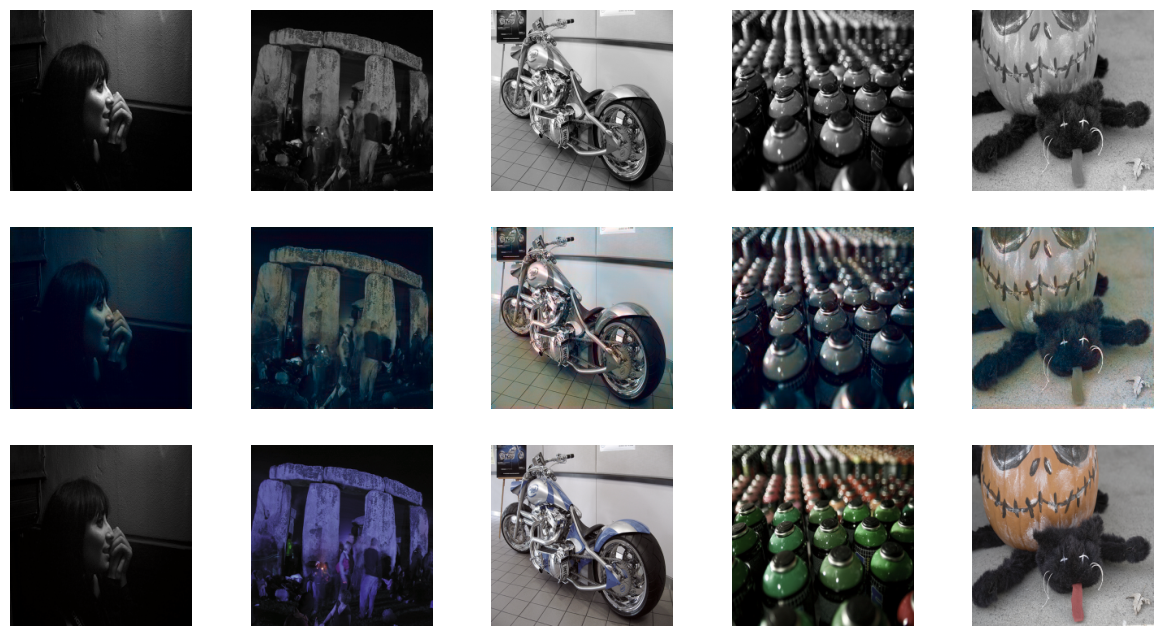


Epoch 1/10
Iteration 200/1563
loss_D_fake: 0.51298
loss_D_real: 0.49731
loss_D: 0.50514
loss_G_GAN: 1.50033
loss_G_L1: 10.04886
loss_G: 11.54919


C:\Users\Plaksha\AppData\Local\Temp\ipykernel_10528\414019884.py:93: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5 negative Z values that have been clipped to zero
  img_rgb = lab2rgb(img)


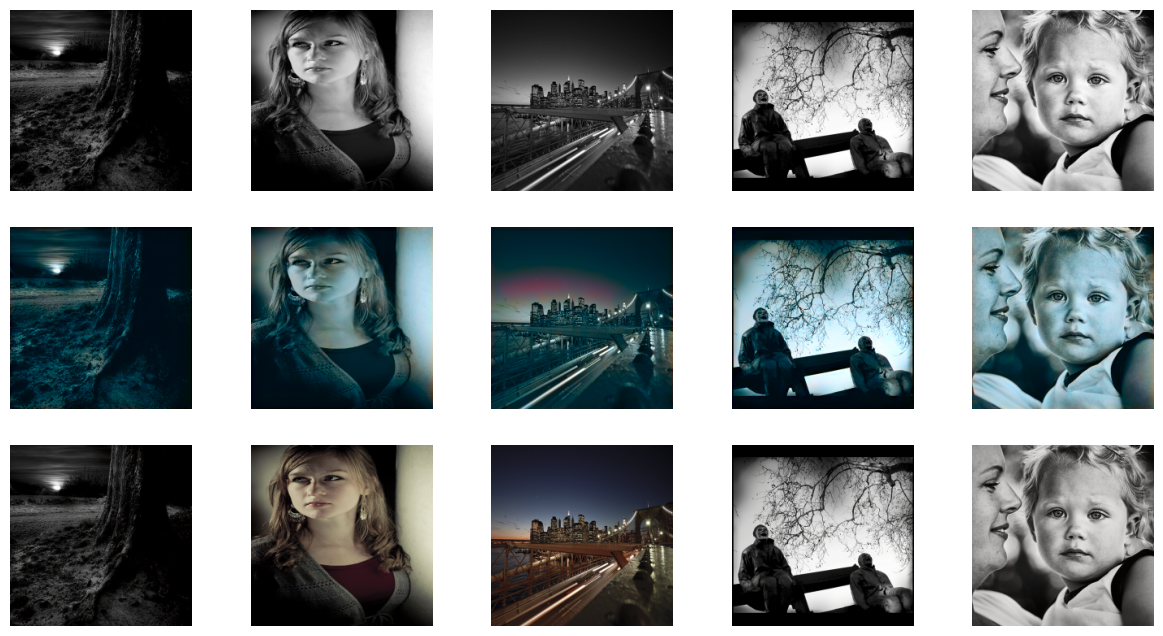

In [ ]:
# Initialize the main model
model = MainModel(net_G=net_G)

# Train the model
train_model(model, train_dl, val_dl, epochs=10, display_every=50)

# Save the final model weights
torch.save(model.state_dict(), "C:/Users/Plaksha/Desktop/ISB/Project _CV/final_model_weights.pt")

print("Model training complete and weights saved")
